# Classification with Logistic Regression

DS 5001 Text as Data

# Overview 

1. $X \rightarrow x$
2. $x \dot W = y^\prime$
3. $f(y^\prime) = y$ 

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'winereviews'
data_path = f"{data_home}/{data_prefix}/{data_prefix}"

## Import

In [3]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.linear_model import LogisticRegression

# Preparation

## Get Data

In [4]:
X_test = pd.read_pickle(f"{data_path}-X_test.csv.pickle").sort_index()
X_train = pd.read_pickle(f"{data_path}-X_train.csv.pickle").sort_index()
y_test = pd.read_pickle(f"{data_path}-y_test.csv.pickle").sort_index()
y_train = pd.read_pickle(f"{data_path}-y_train.csv.pickle").sort_index()

In [5]:
DOC = pd.read_csv(f"{data_path}-DOC_UNSPLIT.csv").set_index('doc_id')

# Apply Model

In [6]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [7]:
# y_hat = pd.DataFrame(clf.predict(X_test), index=X_test.index)

In [10]:
LOGPROB = pd.DataFrame(clf.predict_log_proba(X_test), index=X_test.index)
LOGPROB.columns = clf.classes_

In [11]:
y_hat = LOGPROB.idxmax(1)

# Evaluation

In [10]:
clf.score(X_test, y_test)

0.822

In [12]:
RESULT = pd.concat([y_test, y_hat], axis=1)
RESULT.columns = ['doc_label', 'prediction']

In [13]:
RESULT['result'] = RESULT.doc_label == RESULT.prediction

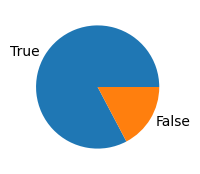

In [14]:
RESULT.value_counts('result').plot.pie(figsize=(2,2));

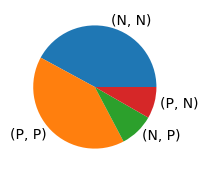

In [15]:
RESULT.value_counts(['prediction','doc_label']).plot.pie(figsize=(2,2));

In [16]:
X = RESULT.join(LOGPROB).join(DOC[['doc_content','points','doc_len']], how='inner').reset_index()

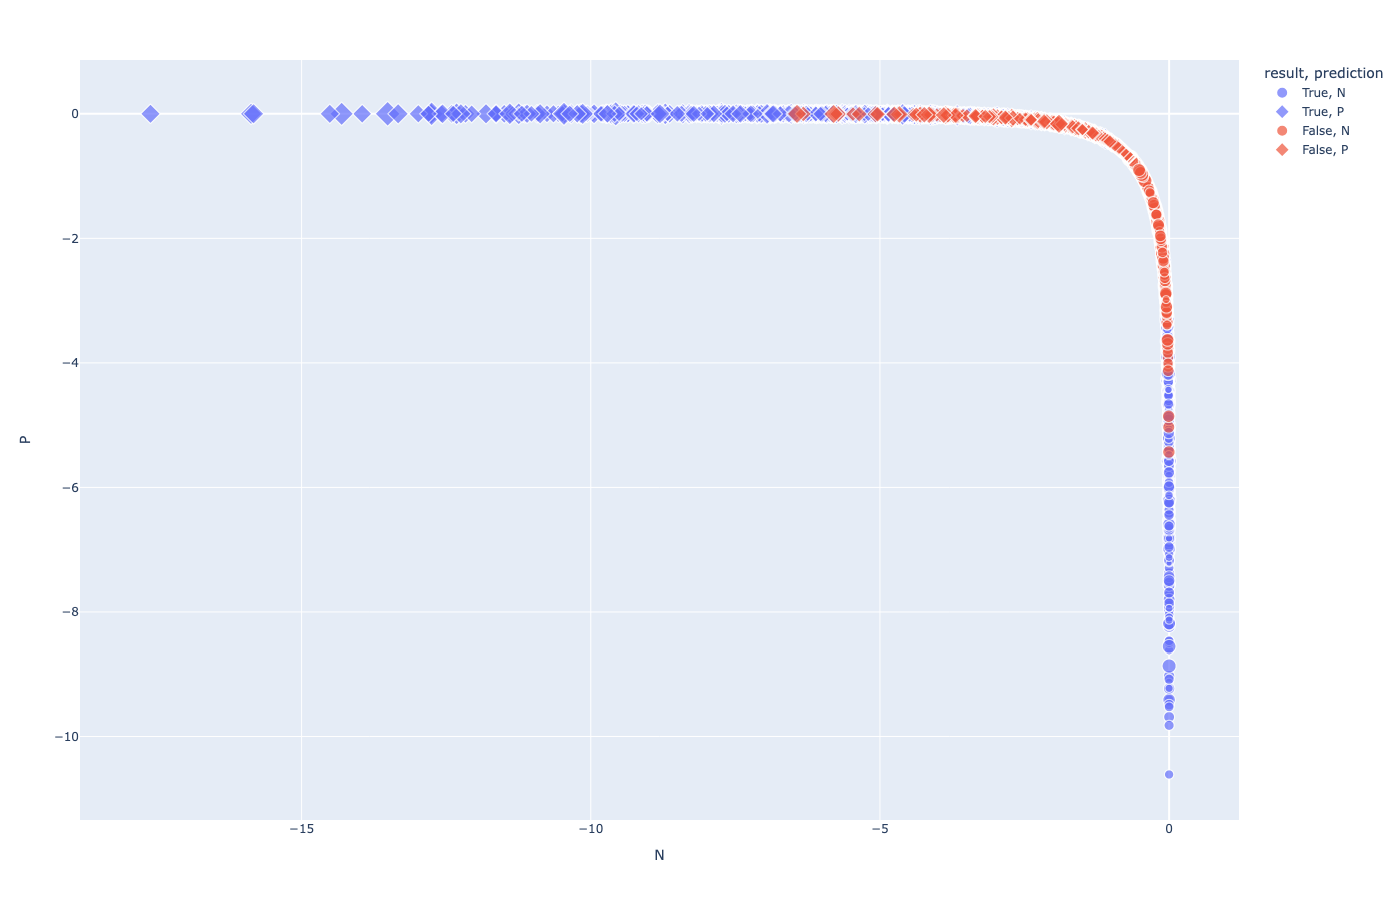

In [37]:
px.scatter(X, 'N', 'P', 
        color='result', symbol='prediction', size='doc_len',
          height=900, width=1000)

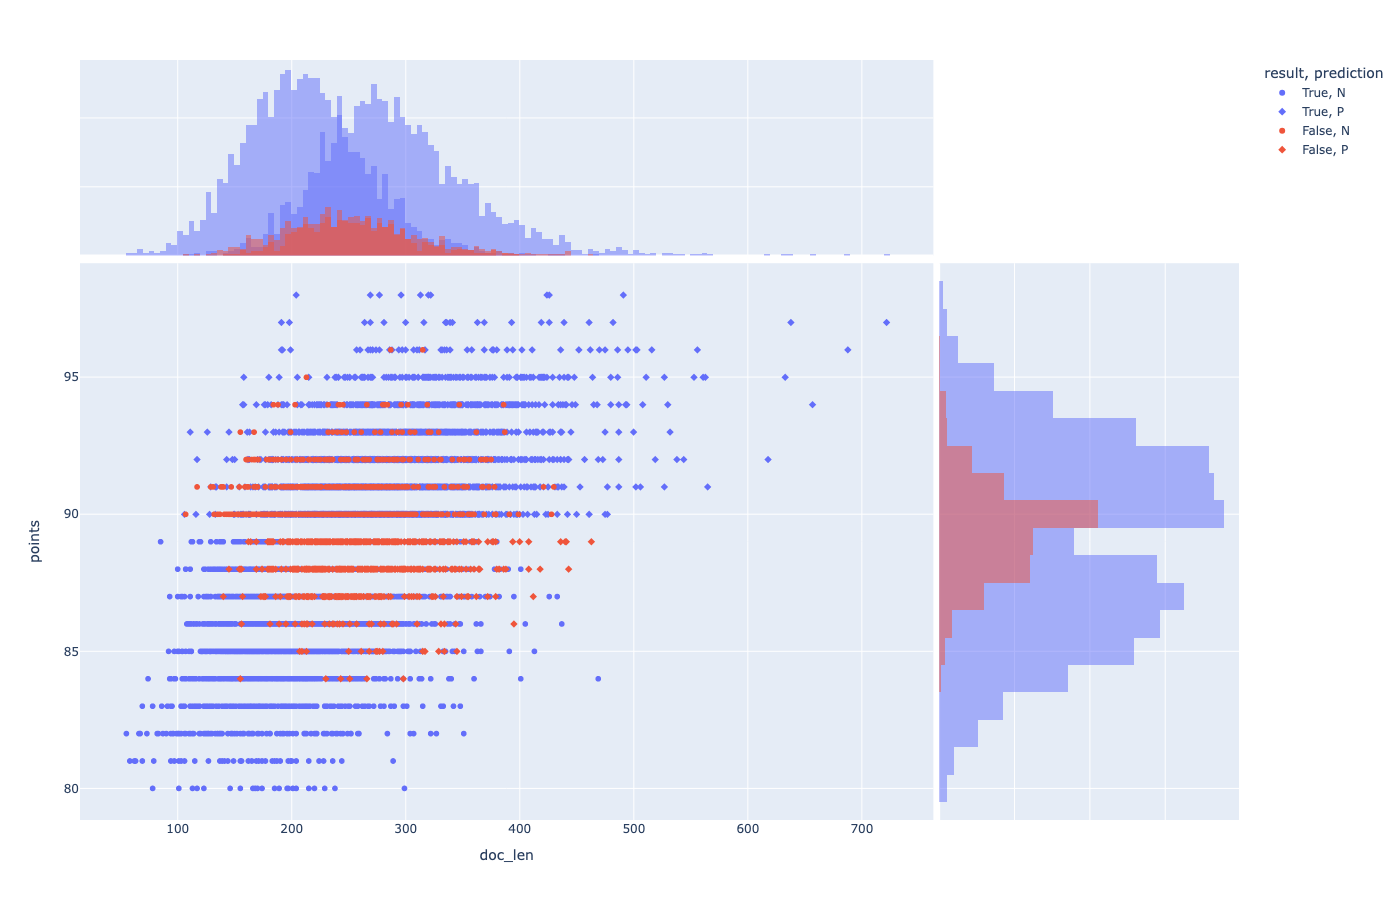

In [18]:
px.scatter(RESULT.join(DOC[['doc_content','points','doc_len']], how='inner').reset_index(), 
           'doc_len', 'points', 
           color='result',
           symbol='prediction',
           height=900, width=1000, marginal_x='histogram', marginal_y='histogram')

In [19]:
CM = RESULT.value_counts(['prediction','doc_label']).unstack()

In [20]:
CM

doc_label      N     P
prediction            
N           3367   720
P            662  3251

In [21]:
def get_results(CM, model_id):
    
    R = pd.DataFrame(index=[model_id])
    R.index.name = 'model_id'
    
    # COUNTS
    R['TN'] = CM.iloc[0,0]   # correct rejections
    R['FN'] = CM.iloc[0,1]   # Type II errors or misses
    R['TP'] = CM.iloc[1,1]   # hits
    R['FP'] = CM.iloc[1,0]   # Type I errors or false alarms
    R['T'] = R.TP + R.TN     # All True
    R['F'] = R.FP + R.FN     # All False
    R['ALL'] = R['T'] + R.F  # All
    
    assert R.ALL.values[0] == CM.sum().sum()
    
    # RATIOS
    R['ACC'] = R['T'] / R.ALL                        # (Simple) Accuracy
    R['TPR'] = R.TP / (R.TP + R.FN)                  # Recall or Sensitivity
    R['TNR'] = R.TN / (R.TN + R.FP)                  # Specificity
    R['PPV'] = R.TP / (R.TP + R.FP)                  # Precision or Positive predictive value 
    R['BA'] = (R.TNR + R.TPR) / 2                    # Balanced Accuracy
    R['F1'] = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN) # F-score where F = 1

    return R

In [22]:
R = get_results(CM, 'logreg')

In [23]:
R.T.style.format(precision=3)

# Extract Sentiment

We treat weight as valence.

In [24]:
SALEX = pd.DataFrame(dict(valence=clf.coef_[0]), index=clf.feature_names_in_)
SALEX.index.name = 'term_str'
SALEX = SALEX.sort_values('valence')
SALEX['polarity'] = np.sign(SALEX['valence'])

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
scaler = MinMaxScaler(feature_range=(-1, 1))
SALEX['normalized'] = scaler.fit_transform(SALEX[['valence']])

In [27]:
SALEX.sort_values('valence', ascending=False).head(20)

valence  polarity  normalized
term_str                                   
92           3.243837       1.0    1.000000
91           2.791660       1.0    0.830094
2023         2.665845       1.0    0.782819
2024         2.629957       1.0    0.769333
fascinating  2.351088       1.0    0.664548
2022         2.270547       1.0    0.634284
2030         2.258621       1.0    0.629803
2025         2.236256       1.0    0.621399
2021         2.071407       1.0    0.559457
2027         2.071287       1.0    0.559412
ageworthy    2.032491       1.0    0.544834
impressive   1.997089       1.0    0.531532
coiled       1.993901       1.0    0.530334
gracefully   1.993871       1.0    0.530323
2020         1.977265       1.0    0.524083
beautiful    1.975289       1.0    0.523340
spätlese     1.907983       1.0    0.498050
interwoven   1.884029       1.0    0.489049
editors      1.847466       1.0    0.475311
terrific     1.822415       1.0    0.465898

In [28]:
SALEX.sort_values('valence', ascending=True).head(20)

valence  polarity  normalized
term_str                                   
everyday    -2.078820      -1.0   -1.000000
lacks       -2.056326      -1.0   -0.991548
disjointed  -1.964785      -1.0   -0.957151
lacking     -1.714746      -1.0   -0.863198
simple      -1.628083      -1.0   -0.830635
lack        -1.543231      -1.0   -0.798751
dimensional -1.504593      -1.0   -0.784233
hollow      -1.478338      -1.0   -0.774367
foamy       -1.450428      -1.0   -0.763880
sharpness   -1.427590      -1.0   -0.755299
solo        -1.402792      -1.0   -0.745981
raspy       -1.352943      -1.0   -0.727250
pizza       -1.342021      -1.0   -0.723146
paired      -1.341114      -1.0   -0.722805
town        -1.338326      -1.0   -0.721757
concludes   -1.324729      -1.0   -0.716648
cropped     -1.318062      -1.0   -0.714143
barsac      -1.315467      -1.0   -0.713168
bourg       -1.293300      -1.0   -0.704839
juiced      -1.284379      -1.0   -0.701487

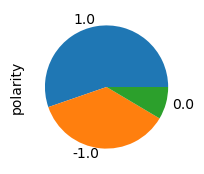

In [29]:
SALEX.polarity.value_counts().plot.pie(figsize=(2,2));

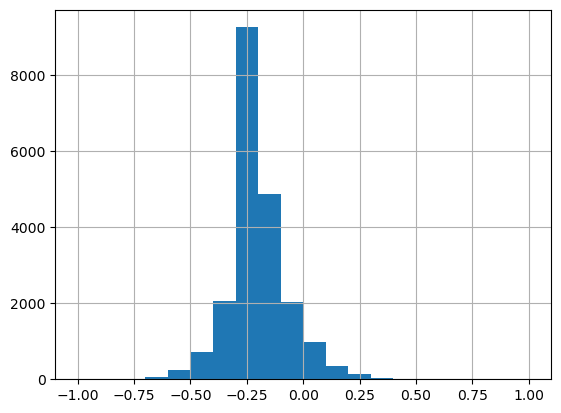

In [30]:
SALEX.normalized.hist(bins=20);

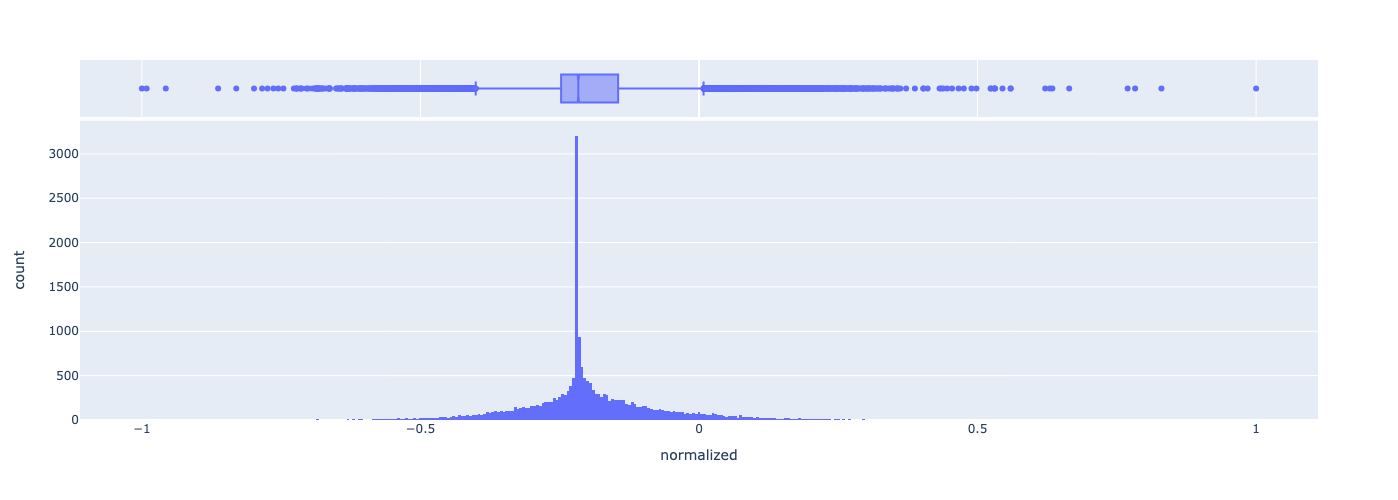

In [31]:
px.histogram(SALEX.reset_index(), x='normalized', hover_name='term_str', marginal='box', width=700, height=500)

In [32]:
(SALEX.normalized < -.3).sum()

3105

In [33]:
(SALEX.normalized > .05).sum()

928

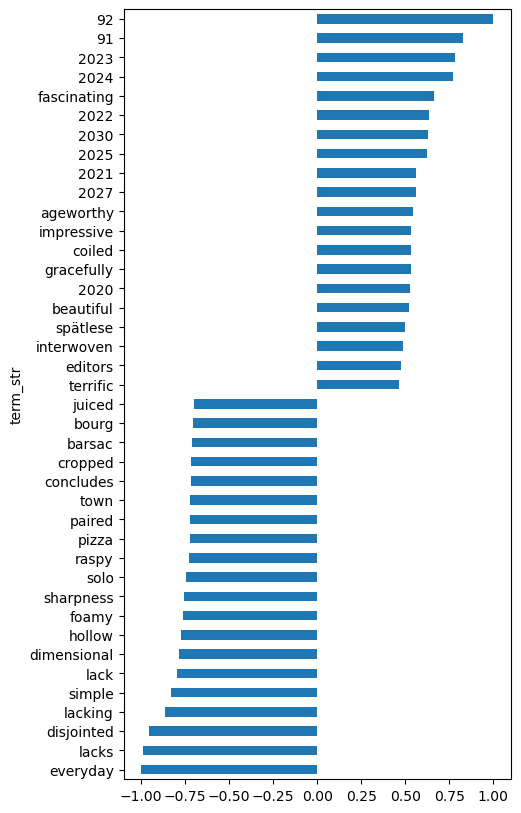

In [34]:
pd.concat([SALEX.normalized.head(20),SALEX.normalized.tail(20)]).plot.barh(figsize=(5,10));

# Save

In [35]:
SALEX.to_csv(f'{data_path}-LOGREG_SALEX.csv')
R.to_csv(f"{data_path}-LOGREG_RESULT.csv", index=True)